In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [46]:
#Specify font sizes for plots:
plt.rcParams['axes.labelsize']  = 22
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

seed=1234
np.random.seed(seed)
tf.set_random_seed(seed)
np.random.seed(1234)

plt.ion() # turn on interactive mode (for plotting)

In [47]:
x_data = np.loadtxt('x_L30.txt',dtype='int8')
y_data = np.loadtxt('y_L30.txt',dtype='int8')
T_data = np.loadtxt('T_L30.txt',dtype='float32')

P = 0.7
mm = x_data.shape[0]
idx_m = np.random.permutation(mm)

train_idx = idx_m[0:round(P*mm)]
validation_idx = idx_m[round(P*mm):round(0.9*mm)]
test_idx = idx_m[round(0.9*mm):mm+1]

X_train = x_data[train_idx]
y_train = y_data[train_idx]

X_val = x_data[validation_idx]
y_val = y_data[validation_idx]

X_test = x_data[test_idx]
y_test = y_data[test_idx]
T_test = T_data[test_idx]

N = 50 # number of points per branch
K = 2  # number of branches
batch_size = 100

In [48]:
############################################################################
##################### DEFINE THE NETWORK ARCHITECTURE ######################
############################################################################

### Create placeholders for the input data and labels ###
### (we'll input actual values when we ask TensorFlow to run an actual computation later) ###
x = tf.placeholder(tf.float32, [None, 900]) # input data
y = tf.placeholder(tf.int32,[None])       # labels

### Layer 1: ###
W1 = tf.Variable( tf.random_normal([900, 120], mean=0.0, stddev=0.01, dtype=tf.float32,seed=1234) )
b1 = tf.Variable( tf.zeros([120]) )
z1 = tf.matmul(x, W1) + b1
a1 = tf.nn.sigmoid( z1 )

W2 = W1 = tf.Variable( tf.random_normal([120, 2], mean=0.0, stddev=0.01, dtype=tf.float32,seed=1234) )
b2 = tf.Variable( tf.zeros([2]) )
z2 = tf.matmul(a1,W2) + b2
a2 = tf.nn.sigmoid(z2)
### Network output: ###
aL = a2

### Cost function: ###
### (measures how far off our model is from the labels) ###
y_onehot = tf.one_hot(y,depth=K) # labels are converted to one-hot representation
eps=0.0000000001 # to prevent the logs from diverging
cross_entropy = tf.reduce_mean(-tf.reduce_sum( y_onehot * tf.log(aL+eps) +  (1.0-y_onehot )*tf.log(1.0-aL +eps) , reduction_indices=[1]))
cost_func = cross_entropy + tf.contrib.layers.l2_regularizer(0.1)(W1) + tf.contrib.layers.l2_regularizer(0.1)(W2)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate  = 0.1 # hyperparameter
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_func)

N_epochs = 50 # number of times to run gradient descent


##############################################################################
################################## TRAINING ##################################
##############################################################################
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epoch_list    = []
cost_training = []
acc_training  = []
cost_validation = []
acc_validation = []


############ Function for plotting: ############
def updatePlot():

    ### Plot the cost function during training: ###
    a = plt.subplot(211)
    a.plot(epoch_list,cost_training,'bo-',label='Training cost')
    a.plot(epoch_list,cost_validation,'g^:',label='Validation cost')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    a.legend(loc='upper right')

    ### Plot the training accuracy: ###
    b=plt.subplot(212)
    b.plot(epoch_list,acc_training,'mo-',label='Training accuracy')
    b.plot(epoch_list,acc_validation,'c^-',label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    b.legend(loc='lower right')
############ End of plotting function ############

### Train for several epochs: ###
for epoch in range(N_epochs):
    sess.run(train_step, feed_dict={x: X_train,y:y_train}) #run gradient descent
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 1 == 0:
        cost1 = sess.run(cost_func,feed_dict={x:X_train, y:y_train})
        cost2 = sess.run(cost_func,feed_dict={x:X_val, y:y_val})
        
        NN_output_train = sess.run(aL,feed_dict={x:X_train, y:y_train})
        predicted_class1 = np.argmax(NN_output_train, axis=1)
        accuracy1 = np.mean(predicted_class1 == y_train)
        
        NN_output_val = sess.run(aL,feed_dict={x:X_val, y:y_val})
        predicted_class2 = np.argmax(NN_output_val,axis=1)
        accuracy2 = np.mean(predicted_class2 == y_val)
        
#         print( "Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost1, accuracy1) )
#         print( "Iteration %d:\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, cost2, accuracy2) )  
        
        epoch_list.append(epoch)
        cost_training.append(cost1)
        cost_validation.append(cost2)
        acc_training.append(accuracy1)
        acc_validation.append(accuracy2)
        
#         ### Update the plot of the resulting classifier: ###
#         fig = plt.figure(2,figsize=(10,5))
#         fig.subplots_adjust(hspace=.3,wspace=.3)
#         plt.clf()
#         updatePlot()
#         plt.pause(0.1)

# plt.savefig('spiral_results1.png') # Save the figure showing the results in the current directory
# plt.show()

In [49]:
a = sess.run(aL, feed_dict={x:X_test,y:y_test})
predicted_class3 = np.argmax(a, axis=1)
accuracy3 = np.mean(predicted_class3 == y_test)

In [51]:
from sklearn.metrics import accuracy_score

# averaging accuracy
u_T = np.unique(T_test)
a_mean = []
for T in u_T:
    idx = T_test == T
    a_T = accuracy_score(predicted_class3[idx], y_test[idx])
    a_mean.append(a_T)


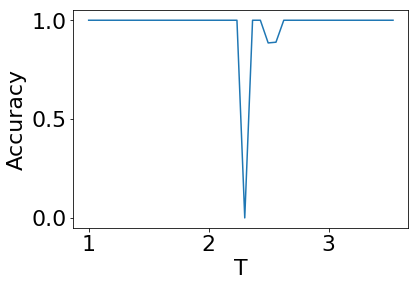

In [52]:
plt.plot(u_T, a_mean)
plt.xlabel("T")
plt.ylabel("Accuracy")
plt.show()

In [58]:
a1_mean = []
a2_mean = []

for T in u_T:
    idx = T_test == T
    a1_T = np.mean(a[idx, 0])
    a2_T = np.mean(a[idx, 1])
    a1_mean.append(a1_T)
    a2_mean.append(a2_T)

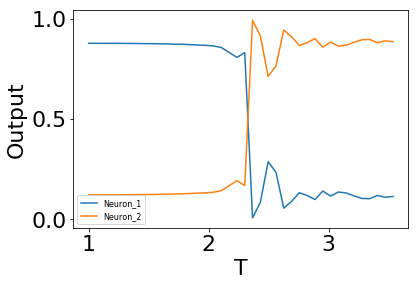

In [68]:
plt.plot(u_T, a1_mean, label="Neuron_1")
plt.plot(u_T, a2_mean, label="Neuron_2")
plt.xlabel("T")
plt.ylabel("Output")
plt.legend(loc=3, prop={'size': 8})
plt.show()